## Observations and Insights 

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from scipy.stats import sem
import numpy as np

In [2]:
# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_df = pd.read_csv(mouse_metadata_path)
results_df = pd.read_csv(study_results_path)

# Combine the data into a single dataset
combined_df = pd.merge(mouse_df, results_df, on='Mouse ID', how='outer')

# Display the data table for preview
combined_df

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


In [3]:
# Checking the number of mice.
mice = len(combined_df['Mouse ID'].unique())
mice

249

In [4]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
# Grouped DF by timepoint
timepoint_grp = combined_df.groupby(['Timepoint'])

# Created a series counting the occurence of each ID within each timepoint ID group
counts = timepoint_grp['Mouse ID'].value_counts()

# Create a new DF from the series
counts_df = pd.DataFrame(counts)

# Rename the counts column
counts_df = counts_df.rename(columns={'Mouse ID':'ID Count'})

# Identify the duplicates (IDs that appear more than once in each timepoint)
duplicates_df = counts_df.loc[counts_df['ID Count'] > 1]
duplicates_df

,,ID Count
Timepoint,Mouse ID,
0,g989,2
5,g989,2
10,g989,2
15,g989,2
20,g989,2


In [5]:
# Optional: Get all the data for the duplicate mouse ID. 
combined_df.loc[combined_df['Mouse ID'] == 'g989']

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
908,g989,Propriva,Female,21,26,0,45.000000,0
909,g989,Propriva,Female,21,26,0,45.000000,0
910,g989,Propriva,Female,21,26,5,48.786801,0
911,g989,Propriva,Female,21,26,5,47.570392,0
912,g989,Propriva,Female,21,26,10,51.745156,0
913,g989,Propriva,Female,21,26,10,49.880528,0
914,g989,Propriva,Female,21,26,15,51.325852,1
915,g989,Propriva,Female,21,26,15,53.442020,0
916,g989,Propriva,Female,21,26,20,55.326122,1
917,g989,Propriva,Female,21,26,20,54.657650,1


In [6]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
# Created a sorted DF by timepoint and mouse ID.
sorted_df = combined_df.sort_values(['Timepoint', 'Mouse ID'])

# Created a cleaned DF dropping duplicates based on the timepoint and mouse ID columns.
clean_df = sorted_df.drop_duplicates(subset=['Timepoint', 'Mouse ID'], 
                                     keep='first')

clean_df

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
454,a203,Infubinol,Female,20,23,0,45.000000,0
464,a251,Infubinol,Female,21,25,0,45.000000,0
474,a262,Placebo,Female,17,29,0,45.000000,0
484,a275,Ceftamin,Female,20,28,0,45.000000,0
494,a366,Stelasyn,Female,16,29,0,45.000000,0
...,...,...,...,...,...,...,...,...
1855,y865,Ceftamin,Male,23,26,45,64.729837,3
84,z578,Ramicane,Male,11,16,45,30.638696,0
1872,z581,Infubinol,Female,24,25,45,62.754451,3
1882,z795,Naftisol,Female,13,29,45,65.741070,3


In [7]:
# Checking the number of mice in the clean DataFrame.
id_check = len(clean_df['Mouse ID'].unique())
id_check

249

## Summary Statistics

In [8]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
# This method is the most straighforward, creating multiple series and putting them all together at the end.

# Identified unique regimens
regimen = clean_df['Drug Regimen'].unique().tolist()

# Lists created to contain information for each regimen
mean = []
median = []
var = []
sd = []
sem_list = []

# Used a loop to extract calculations for each regimen
for x in regimen:
    regimen_df = clean_df.loc[clean_df['Drug Regimen'] == x]
    mean.append(regimen_df['Tumor Volume (mm3)'].mean())
    median.append(regimen_df['Tumor Volume (mm3)'].median())
    var.append((regimen_df['Tumor Volume (mm3)'].var()))
    sd.append(regimen_df['Tumor Volume (mm3)'].std())
    sem_list.append(sem(regimen_df['Tumor Volume (mm3)']))

# Created DF
summary_df1 = pd.DataFrame({'Drug Regimen': regimen,
                            'Mean': mean,
                            'Median': median,
                            'Variance' : var,
                            'Standard Deviation' : sd,
                            'SEM': sem_list})

# Set and sorted the DF index
summary_df1 = summary_df1.set_index('Drug Regimen')
summary_df1.sort_index()

,Mean,Median,Variance,Standard Deviation,SEM
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.393463,50.909965,43.138803,6.568014,0.525862
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [9]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# This method produces everything in a single groupby function
# Grouped data by regimen
regimen_grp = clean_df.groupby('Drug Regimen')

# Mean
mean2 = regimen_grp['Tumor Volume (mm3)'].mean()

# Median
median2 = regimen_grp['Tumor Volume (mm3)'].median()

# Variance
var2 = regimen_grp['Tumor Volume (mm3)'].var()

# Standard deviation
sd2 = regimen_grp['Tumor Volume (mm3)'].std()

# SEM
sem2 = regimen_grp['Tumor Volume (mm3)'].sem()

# Created DF
summary_df2 = pd.DataFrame({'Mean': mean2,
                            'Median': median2,
                            'Variance' : var2,
                            'Standard Deviation' : sd2,
                            'SEM': sem2})
summary_df2

,Mean,Median,Variance,Standard Deviation,SEM
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.393463,50.909965,43.138803,6.568014,0.525862
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


## Bar and Pie Charts

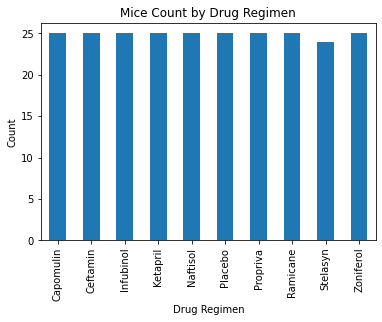

In [10]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pandas.

# The above instructions were interpreted as a request to 
# provide a bar chart of the number of unique mice that were 
# initially used for each drug regimen. 

# Created series that only holds unique Mouse IDs (grouped by drug regimen) 
rx = clean_df.drop_duplicates(subset='Mouse ID').groupby('Drug Regimen')
rx = rx['Mouse ID'].count()

# Plotted the mice count by drug regimen
rx_plot = rx.plot.bar(rot=90, title='Mice Count by Drug Regimen')
# Assigned a y-axis label
rx_plot.set_ylabel('Count')
plt.show()

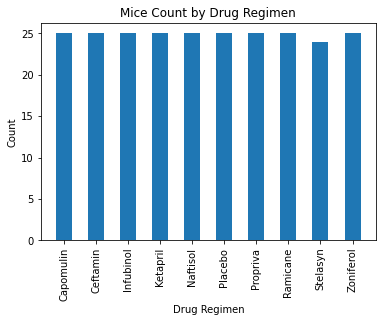

In [11]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pyplot.

# The above instructions were interpreted as a request to 
# provide a bar chart of the number of unique mice that were 
# initially used for each drug regimen. 

# Created an x-axis variable to hold the name of each drug regimen
x_axis = [value for value in rx.index]

# Created an y-axis variable to hold the count of mice used to 
# test each drug regimen.
y_axis = [rx[i] for i in np.arange(len(rx))]

# Created valued for each tick location
tick_locations = [value for value in np.arange(len(x_axis))]

# Created a bar chart with a title and axis labels
plt.bar(x_axis, y_axis, width=.5, align = 'center')
plt.xticks(tick_locations, rotation='vertical')
plt.title('Mice Count by Drug Regimen')
plt.xlabel('Drug Regimen')
plt.ylabel('Count')
plt.show()

In [12]:
#Test 1
# regimen_grp = clean_df.groupby('Drug Regimen')
# regimen_grp_count = regimen_grp['Timepoint'].value_counts()
# regimen_grp_count.head(20)
# xticks = [1 for x in np.arange(regimen_grp_count.count())]
# fig, ax = plt.subplots()
# regimen_grp_count.plot.bar()
# plt.show()

# #Test 2
# regimen_grp = clean_df.groupby('Timepoint')
# regimen_grp_count = regimen_grp['Drug Regimen'].value_counts()
# regimen_grp_count.head()
# xticks = [1 for x in np.arange(regimen_grp_count.count())]

# fig, ax = plt.subplots(figsize=(20,10)) ## plotting in axis, matplotlib api
# ##sizes in pandas are pixel equivalent of inches
# regimen_grp_count.plot.bar(ax = ax)

# plt.figure(figsize=(15,8))

# plt.show()
# ##grid plot

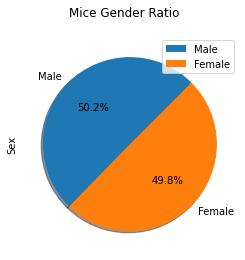

In [13]:
# Generate a pie plot showing the distribution of female versus male mice using pandas

# Created a DF to reflect the gender counts associated with each
# unique mouse ID
gender = pd.DataFrame(clean_df.drop_duplicates(subset='Mouse ID'))
gender = pd.DataFrame(gender['Sex'].value_counts())

# Plotted the mice count by drug regimen
gender.plot.pie(subplots=True, 
                autopct='%1.1f%%', 
                title='Mice Gender Ratio',
                startangle=45,
                shadow=True)
plt.show()

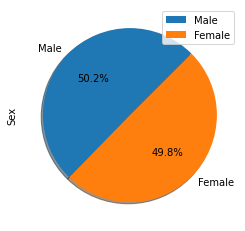

In [14]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot

# Referenced prior DF for labels and the gender count
labels = [value for value in gender.index]
gend_count = gender['Sex'].tolist()

# Plotted the pie chart
fig, ax = plt.subplots()
ax.pie(gend_count, 
       labels=labels, 
       autopct='%1.1f%%', 
       startangle=45,
       shadow=True)
plt.ylabel('Sex')
plt.legend(labels, loc='best')
plt.show()

## Quartiles, Outliers and Boxplots

In [15]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse

# Created new series that is grouped by Mouse ID with only the max values of the Timepoint column.
mt = clean_df.groupby(['Mouse ID'])['Timepoint'].max()
# Created DF from series and reset the index
mt_df = pd.DataFrame(mt)
mt_df = mt_df.reset_index() 

# Merge this group df with the original dataframe to get the tumor volume at the last timepoint
merged_df = mt_df.merge(clean_df, how='left', on=['Mouse ID', 'Timepoint'])

merged_df

,Mouse ID,Timepoint,Drug Regimen,Sex,Age_months,Weight (g),Tumor Volume (mm3),Metastatic Sites
0,a203,45,Infubinol,Female,20,23,67.973419,2
1,a251,45,Infubinol,Female,21,25,65.525743,1
2,a262,45,Placebo,Female,17,29,70.717621,4
3,a275,45,Ceftamin,Female,20,28,62.999356,3
4,a366,30,Stelasyn,Female,16,29,63.440686,1
...,...,...,...,...,...,...,...,...
244,z435,10,Propriva,Female,12,26,48.710661,0
245,z578,45,Ramicane,Male,11,16,30.638696,0
246,z581,45,Infubinol,Female,24,25,62.754451,3
247,z795,45,Naftisol,Female,13,29,65.741070,3


In [16]:
# Updated Code
# Put treatments into a list for for loop (and later for plot labels)
treatments = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']

# Create empty list to fill with tumor vol data (for plotting)
final_tumor_vol = []

# Created emppty lists to hold treatment quartile data
drug_quartiles = []
drug_lowerq = []
drug_upperq = []
drug_iqr = []
drug_lower_bound = []
drug_upper_bound = []
drug_outliers = []

for drug in treatments:
    drug_series = merged_df.loc[merged_df["Drug Regimen"] == drug, 'Tumor Volume (mm3)']

    # Calculate the IQR and quantitatively determine if there are any potential outliers. 
    quartiles = drug_series.quantile([.25,.5,.75])
    drug_quartiles.append(quartiles)
    
    lowerq = quartiles[0.25]
    drug_lowerq.append(lowerq)
    
    upperq = quartiles[0.75]
    drug_upperq.append(upperq)
    
    iqr = upperq - lowerq
    drug_iqr.append(iqr)
    
    # add subset 
    final_tumor_vol.append(drug_series)

    # Determine outliers using upper and lower bounds
    lower_bound = lowerq - (1.5 * iqr)
    drug_lower_bound.append(lower_bound)
    
    upper_bound = upperq + (1.5 * iqr)
    drug_upper_bound.append(upper_bound)
    
    drug_df = merged_df.loc[merged_df['Drug Regimen'] == drug, ['Tumor Volume (mm3)']]
    drug_df = drug_df.loc[(drug_df['Tumor Volume (mm3)'] < lower_bound) | 
                          (drug_df['Tumor Volume (mm3)'] > upper_bound)]
    outliers = len(drug_df['Tumor Volume (mm3)'])
    drug_outliers.append(outliers)

# Created a DF to present reatment quartile data
quartile_data = pd.DataFrame(
    {'Drug Regimen': treatments,
     'Lower Quartile': drug_lowerq,
     'Upper Quartile': drug_upperq,
     'IQR': drug_iqr,
     'Lower Bound': drug_lower_bound,
     'Upper Bound': drug_upper_bound,
     'Outliers': drug_outliers})

quartile_data

,Drug Regimen,Lower Quartile,Upper Quartile,IQR,Lower Bound,Upper Bound,Outliers
0,Capomulin,32.377357,40.159220,7.781863,20.704562,51.832015,0
1,Ramicane,31.560470,40.659006,9.098537,17.912664,54.306811,0
2,Infubinol,54.048608,65.525743,11.477135,36.832905,82.741446,1
3,Ceftamin,48.722078,64.299830,15.577752,25.355450,87.666458,0


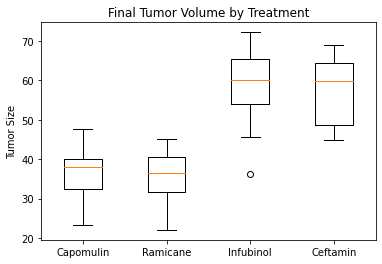

In [17]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
fig1, ax1 = plt.subplots()
ax1.set_title('Final Tumor Volume by Treatment')
ax1.set_ylabel('Tumor Size')
ax1.boxplot(final_tumor_vol, labels=treatments)
plt.show()

## Line and Scatter Plots

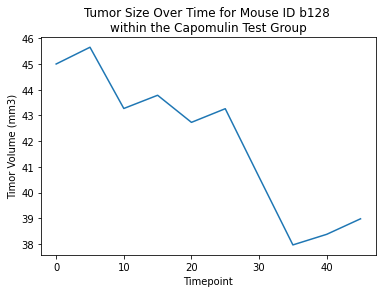

In [60]:
# Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin
# Pulled information into a new DF for Mouse ID b128 for the specified drug 
mouse_id = 'b128'
drug = 'Capomulin'
indv_mouse = clean_df.loc[(clean_df["Drug Regimen"] == drug) & (clean_df['Mouse ID']== mouse_id)]

# Plotted information
plt.plot(indv_mouse['Timepoint'], indv_mouse['Tumor Volume (mm3)']) 
plt.title(f'Tumor Size Over Time for Mouse ID {mouse_id} \n within the {drug} Test Group')
plt.xlabel('Timepoint')
plt.ylabel('Timor Volume (mm3)')
plt.show()


In [72]:
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen
# Pulled information into a new DF for the specified drug 
weight_df = clean_df.loc[(clean_df["Drug Regimen"] == drug)]

# # Plotted information
# plt.scatter(weight_df['Tumor Volume (mm3)'],
#             weight_df['Weight (g)'], 
             
#             marker='o', 
#             facecolors='b', 
#             alpha=.60)
#           # title='Weight Gain vs. Tumor Volume')
# plt.title(f'Mouse Weight Gain vs. Tumor Volume \n within the {drug} Test Group ')
# plt.xlabel('Tumor Volume')
# plt.ylabel('Mouse Weight')
# plt.show()

## Correlation and Regression

In [ ]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
